In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


# 1. Data Acquisition:

In [15]:

# Define file paths
file_paths = {
    'SpamAssasin': 'phishing-email-dataset/SpamAssasin.csv',
    'Nigerian_Fraud': 'phishing-email-dataset/Nigerian_Fraud.csv',
    'Phishing_Email': 'phishing-email-dataset/phishing_email.csv',
    'CEAS_08': 'phishing-email-dataset/CEAS_08.csv',
    'Enron': 'phishing-email-dataset/Enron.csv',
    'Ling': 'phishing-email-dataset/Ling.csv',
    'Nazario': 'phishing-email-dataset/Nazario.csv'
}

In [16]:

# Load and explore each dataset
datasets = {}
spam_nonspam_counts = {}

for name, path in file_paths.items():
    try:
        df = pd.read_csv(path)
        datasets[name] = df
        
        print(f"\n{name} Dataset:")
        print(f"Shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        
        # Check if 'label' column exists
        if 'label' in df.columns:
            spam_count = df[df['label'] == 1].shape[0]
            non_spam_count = df[df['label'] == 0].shape[0]
            print(f"Spam: {spam_count}, Non-spam: {non_spam_count}")
        else:
            spam_count = df.shape[0]
            non_spam_count = 0
            print(f"All emails considered as spam: {spam_count}")
        
        spam_nonspam_counts[name] = {
            'spam_count': spam_count,
            'non_spam_count': non_spam_count
        }
        
    except FileNotFoundError:
        print(f"File not found: {path}")
    except Exception as e:
        print(f"Error loading {name}: {str(e)}")
        
# Display summary
print("\n" + "="*50)
print("SUMMARY OF ALL DATASETS:")
print("="*50)
for dataset, counts in spam_nonspam_counts.items():
    print(f"{dataset}: {counts['spam_count']} spam, {counts['non_spam_count']} non-spam")



SpamAssasin Dataset:
Shape: (5809, 7)
Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']
Spam: 1718, Non-spam: 4091

Nigerian_Fraud Dataset:
Shape: (3332, 7)
Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'urls', 'label']
Spam: 3332, Non-spam: 0

Phishing_Email Dataset:
Shape: (82486, 2)
Columns: ['text_combined', 'label']
Spam: 42891, Non-spam: 39595

CEAS_08 Dataset:
Shape: (39154, 7)
Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']
Spam: 21842, Non-spam: 17312

Enron Dataset:
Shape: (29767, 3)
Columns: ['subject', 'body', 'label']
Spam: 13976, Non-spam: 15791

Ling Dataset:
Shape: (2859, 3)
Columns: ['subject', 'body', 'label']
Spam: 458, Non-spam: 2401

Nazario Dataset:
Shape: (1565, 7)
Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'urls', 'label']
Spam: 1565, Non-spam: 0

SUMMARY OF ALL DATASETS:
SpamAssasin: 1718 spam, 4091 non-spam
Nigerian_Fraud: 3332 spam, 0 non-spam
Phishing_Email: 42891 spam, 39595

# 2. Data Cleaning and Preprocessing:

In [17]:

# =============================================================================
# Data Preprocessing và Combination
# =============================================================================

def preprocess_text(df):
    """Basic text preprocessing"""
    df = df.copy()
    
    # Remove null values
    df = df.dropna(subset=['text'])
    
    # Convert text to lowercase
    df['text'] = df['text'].astype(str).str.lower()
    
    # Remove extra whitespace
    df['text'] = df['text'].str.strip()
    
    # Remove empty strings
    df = df[df['text'].str.len() > 0]
    
    return df

# Combine datasets that have text content
combined_data = []

for name, df in datasets.items():
    print(f"\nProcessing {name}...")
    
    # Check for text columns
    text_column = None
    if 'text_combined' in df.columns:
        text_column = 'text_combined'
    elif 'text' in df.columns:
        text_column = 'text'
    elif 'body' in df.columns:
        text_column = 'body'
    elif 'content' in df.columns:
        text_column = 'content'
    
    if text_column:
        # Prepare dataframe
        df_subset = df[[text_column]].copy()
        
        # Add label column
        if 'label' in df.columns:
            df_subset['label'] = df['label']
        else:
            df_subset['label'] = 1  # Assume all are spam
        
        # Rename text column
        df_subset.columns = ['text', 'label']
        
        combined_data.append(df_subset)
        print(f"Added {len(df_subset)} emails from {name}")
    else:
        print(f"No text column found in {name}")

# Combine all datasets
if combined_data:
    combined_df = pd.concat(combined_data, ignore_index=True)
    print(f"\nCombined dataset created with {len(combined_df)} emails")
    
    # Preprocess text
    combined_df = preprocess_text(combined_df)
    print(f"After preprocessing: {len(combined_df)} emails")
    
    # Show class distribution
    print(f"\nClass distribution:")
    print(combined_df['label'].value_counts())
    
    # Show sample data
    print(f"\nSample data:")
    print(combined_df.head())
    
else:
    print("No datasets with text content found!")


import os

# Specify your folder path
folder_path = '.'  # Replace with your actual folder path
os.makedirs(folder_path, exist_ok=True)

# Save the DataFrame as CSV in that folder
file_path = os.path.join(folder_path, 'combined_dataset.csv')
combined_df.to_csv(file_path, index=False, encoding='utf-8-sig')

print(f"File saved to {file_path}")



Processing SpamAssasin...
Added 5809 emails from SpamAssasin

Processing Nigerian_Fraud...
Added 3332 emails from Nigerian_Fraud

Processing Phishing_Email...
Added 82486 emails from Phishing_Email

Processing CEAS_08...
Added 39154 emails from CEAS_08

Processing Enron...
Added 29767 emails from Enron

Processing Ling...
Added 2859 emails from Ling

Processing Nazario...
Added 1565 emails from Nazario

Combined dataset created with 164972 emails
After preprocessing: 164966 emails

Class distribution:
label
1    85776
0    79190
Name: count, dtype: int64

Sample data:
                                                text  label
0  date:        wed, 21 aug 2002 10:54:46 -0500  ...      0
1  martin a posted:\ntassos papadopoulos, the gre...      0
2  man threatens explosion in moscow \n\nthursday...      0
3  klez: the virus that won't die\n \nalready the...      0
4  >  in adding cream to spaghetti carbonara, whi...      0
File saved to ./combined_dataset.csv


# 3. Exploratory Data Analysis

Text length statistics:
         count         mean           std  min    25%    50%     75%  \
label                                                                  
0      79190.0  1847.441899   4629.092082  1.0  457.0  907.0  1805.0   
1      85776.0  1224.407025  22067.113168  1.0  228.0  424.0  1242.0   

             max  
label             
0       299201.0  
1      4599644.0  


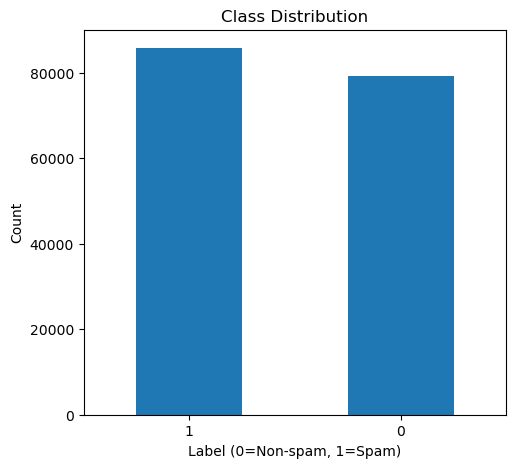

In [18]:
# Visualize class distribution
plt.figure(figsize=(12, 5))

# Class distribution
plt.subplot(1, 2, 1)
combined_df['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Label (0=Non-spam, 1=Spam)')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Text length analysis
combined_df['text_length'] = combined_df['text'].str.len()

print("Text length statistics:")
print(combined_df.groupby('label')['text_length'].describe())

# 4. Model Training:

In [19]:

# =============================================================================
# Train-Test Split
# =============================================================================

# Prepare data for training
X = combined_df['text']
y = combined_df['label']

print(f"Total samples: {len(X)}")
print(f"Class distribution: {Counter(y)}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training class distribution: {Counter(y_train)}")
print(f"Test class distribution: {Counter(y_test)}")


Total samples: 164966
Class distribution: Counter({1: 85776, 0: 79190})

Training set size: 115476
Test set size: 49490
Training class distribution: Counter({1: 60043, 0: 55433})
Test class distribution: Counter({1: 25733, 0: 23757})


# 4. Random Forest Pipeline:

In [20]:
# def create_rf_pipeline(use_undersampling=True, max_features=1000):
def create_rf_pipeline(use_undersampling=True, max_features=1000):
    """Create Random Forest pipeline with optional undersampling"""
    if use_undersampling:
        pipeline = ImbPipeline([
            ('tfidf', TfidfVectorizer(              
                max_features=max_features,
                stop_words='english',
                ngram_range=(1, 2),
                min_df=2,
                max_df=0.95,
                lowercase=True,
                strip_accents='unicode'
            )),
            ('undersampler', RandomUnderSampler(random_state=42)),
            ('select', SelectKBest(chi2, k=k_best)), # dimentionality reduction
            ('rf', RandomForestClassifier(
                n_estimators=100,
                random_state=42,
                n_jobs=-1
            ))
        ])
    else:
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(
                max_features=max_features,
                stop_words='english',
                ngram_range=(1, 2),
                min_df=2,
                max_df=0.95,
                lowercase=True,
                strip_accents='unicode'
            )),
            ('rf', RandomForestClassifier(
                n_estimators=100,
                random_state=42,
                n_jobs=-1
            ))
        ])
    return pipeline

# Create Random Forest pipeline
print("Creating Random Forest pipeline...")
pipeline = create_rf_pipeline(use_undersampling=False, max_features=1000)
print("Pipeline created successfully!")
print(f"Pipeline steps: {list(pipeline.named_steps.keys())}")


Creating Random Forest pipeline...
Pipeline created successfully!
Pipeline steps: ['tfidf', 'rf']


# 6. Model Training

In [21]:
# =============================================================================
# Train Model
# =============================================================================

print("Training RF model...")
print("This may take a few minutes...")

# Train the model
pipeline.fit(X_train, y_train)

print("Model training completed!")


Training RF model...
This may take a few minutes...
Model training completed!


# 7. Model Evaluation:

Making predictions...
Test Accuracy: 0.9860

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.99      0.98      0.99     23757
    Phishing       0.98      0.99      0.99     25733

    accuracy                           0.99     49490
   macro avg       0.99      0.99      0.99     49490
weighted avg       0.99      0.99      0.99     49490


Confusion Matrix:
[[23313   444]
 [  251 25482]]


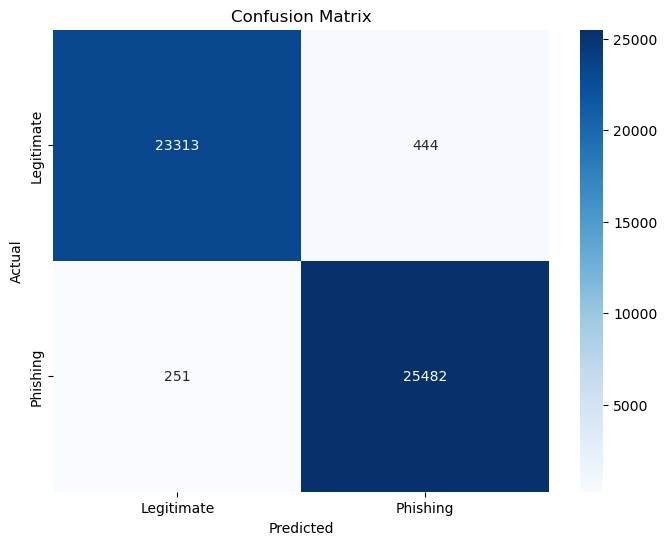

In [22]:
def evaluate_model(pipeline, X_test, y_test, class_names=['Legitimate', 'Phishing']):
    """Evaluate the trained model (no predict_proba)"""
    
    # Make predictions
    print("Making predictions...")
    y_pred = pipeline.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    return accuracy, y_pred

# Evaluate the model
accuracy, y_pred = evaluate_model(pipeline, X_test, y_test)


# 8. Cross-Validation:

Performing cross-validation...
This may take a few minutes...
Cross-validation scores: [0.98302736 0.98302663 0.98415241 0.98289673 0.98151115]
Mean CV score: 0.9829 (+/- 0.0017)


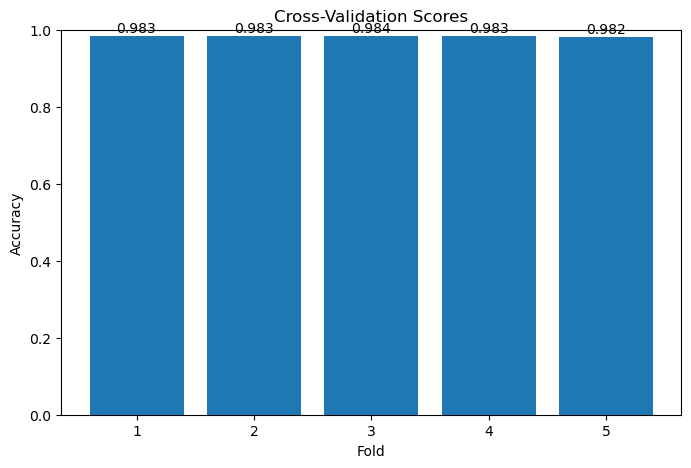

In [23]:

# =============================================================================
# Cross-Validation
# =============================================================================

print("Performing cross-validation...")
print("This may take a few minutes...")

# Perform cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Plot CV scores
plt.figure(figsize=(8, 5))
plt.bar(range(1, 6), cv_scores)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores')
plt.ylim(0, 1)
for i, score in enumerate(cv_scores):
    plt.text(i+1, score + 0.01, f'{score:.3f}', ha='center')
plt.show()


# 9. Threshold Tuning and Finalization:

In [24]:
from sklearn.metrics import precision_recall_curve

def tune_threshold(pipeline, X_val, y_val):
    """Find best classification threshold on validation set to maximize F1 score"""
    proba = pipeline.predict_proba(X_val)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_val, proba)
    
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
    best_idx = f1_scores.argmax()
    best_threshold = thresholds[best_idx]
    
    print(f"Best threshold for F1 score: {best_threshold:.4f} with F1={f1_scores[best_idx]:.4f}")
    return best_threshold

# Example: Split further validation set from training and tune threshold
from sklearn.model_selection import train_test_split
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)
pipeline.fit(X_train_part, y_train_part)
best_thresh = tune_threshold(pipeline, X_val, y_val)

Best threshold for F1 score: 0.4600 with F1=0.9841


In [25]:

# =============================================================================
# Test with Sample Emails
# =============================================================================

# Sample emails for testing
sample_emails = [
    # Phishy examples
    "Your Dropbox account will be suspended due to inactivity. Click the link below to reactivate immediately!",
    "Urgent: You have unpaid invoices. Verify your payment details now to avoid service interruptions.",
    "Microsoft Teams security alert: New login detected. Confirm your identity by clicking here.",
    "You've received a Dropbox file sharing invitation. Open the link to view the document.",
    "Attention: Unusual activity detected in your PayPal account. Verify your account now to secure it.",
    
    # Legitimate examples
    "Hi team, the project deadline is extended to next Friday. Please plan your work accordingly.",
    "Your Amazon order #123456789 has shipped and is expected to arrive by tomorrow.",
    "Reminder: The weekly team meeting is scheduled for Wednesday at 10 AM in the main conference room.",
    "Please find attached the minutes from yesterday's board meeting. Let me know if any changes are needed.",
    "Thank you for submitting your application. We will review it and get back to you within two weeks."
]

print("Testing with sample emails:")
print("=" * 80)

for i, email in enumerate(sample_emails, 1):
    pred = pipeline.predict([email])[0]
    # proba = pipeline.predict_proba([email])[0]
    
    print(f"\nEmail {i}:")
    print(f"Text: {email}")
    print(f"Prediction: {'Phishy' if pred == 1 else 'Legit'}")
    # print(f"Spam Probability: {proba[1]:.4f}")
    # print(f"Non-Spam Probability: {proba[0]:.4f}")
    print("-" * 80)


Testing with sample emails:

Email 1:
Text: Your Dropbox account will be suspended due to inactivity. Click the link below to reactivate immediately!
Prediction: Phishy
--------------------------------------------------------------------------------

Email 2:
Text: Urgent: You have unpaid invoices. Verify your payment details now to avoid service interruptions.
Prediction: Phishy
--------------------------------------------------------------------------------

Email 3:
Text: Microsoft Teams security alert: New login detected. Confirm your identity by clicking here.
Prediction: Phishy
--------------------------------------------------------------------------------

Email 4:
Text: You've received a Dropbox file sharing invitation. Open the link to view the document.
Prediction: Phishy
--------------------------------------------------------------------------------

Email 5:
Text: Attention: Unusual activity detected in your PayPal account. Verify your account now to secure it.
Prediction

# 10. Serialization and Deployment

In [26]:
import joblib

# Save pipeline to a .pkl file
def save_model(pipeline, file_path='phishing_rf_pipeline.pkl'):
    joblib.dump(pipeline, file_path)
    print(f"Model pipeline saved at {file_path}")

# Example usage after training:
save_model(pipeline)


Model pipeline saved at phishing_rf_pipeline.pkl
